Exploratory analysis of the [Databricks Dolly training data](https://huggingface.co/datasets/databricks/databricks-dolly-15k).

In [1]:
%pip install sentence-transformers scipy

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 37.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 120.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 171.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 159.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 9.0 MB/s eta 0:00:0000:0100:01
     ━

In [2]:
import pandas as pd
import numpy as np
import requests
import json

DATA_URL = "https://datasets-server.huggingface.co/rows?dataset=databricks%2Fdatabricks-dolly-15k&config=databricks--databricks-dolly-15k"

lines_per_chunk = 100

chunks = []
chunk_number = 0

while True:
    chunk_offset = chunk_number * lines_per_chunk
    chunk_end = chunk_offset + lines_per_chunk
    resp = requests.get(DATA_URL + f"&split=train&offset={chunk_offset}&limit={chunk_end}", 
                        stream=True)
    chunk_result = next(resp.iter_lines())
    chunk_data = json.loads(chunk_result.decode('utf-8'))
    chunk_rows = [r['row'] for r in chunk_data['rows']]
    if len(chunk_rows) == 0:
        break
    chunks.append(pd.DataFrame(chunk_rows))
    chunk_number += 1

dolly_data = pd.concat(chunks).reset_index()

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 9, Finished, Available)

In [3]:
dolly_data

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 10, Finished, Available)

,index,instruction,context,response,category
0,0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,1,Which is a species of fish? Tope or Rope,,Tope,classification
2,2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa
...,...,...,...,...,...
15006,6,How do i accept the change,,Embrace the change and see the difference,brainstorming
15007,7,What is a laser and who created it?,A laser is a device that emits light through a...,A laser is a device that emits light from an e...,summarization
15008,8,What is the difference between a road bike and...,,Road bikes are built to be ridden on asphalt a...,open_qa
15009,9,How does GIS help in the real estate investmen...,,"Real estate investors depend on precise, accur...",general_qa


In [4]:
dolly_data['has_context'] = [len(x) > 0 for x in dolly_data['context']]

pd.crosstab(dolly_data['category'], dolly_data['has_context'])

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 11, Finished, Available)

has_context,False,True
category,,
brainstorming,1766,0
classification,2136,0
closed_qa,0,1773
creative_writing,709,0
general_qa,2191,0
information_extraction,0,1506
open_qa,3742,0
summarization,0,1188


# Add embeddings

In [5]:
from sentence_transformers import SentenceTransformer
sentxformer = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2') # 'sentence-transformers/all-mpnet-base-v2'

dolly_data['instruction_vector'] = sentxformer.encode(dolly_data['instruction'].values).tolist()
dolly_data['response_vector'] = sentxformer.encode(dolly_data['response'].values).tolist()


StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 12, Finished, Available)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 27, Finished, Available)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 28, Finished, Available)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 29, Finished, Available)

In [6]:
def add_cluster_cols(df, embedding_col='embedding', prefix='cluster', letters='ABCDE', max_threshold=1):
    from scipy.cluster.hierarchy import ward, fcluster
    from scipy.spatial.distance import pdist
    import math

    # cluster the sentence vectors at various levels
    X = df[embedding_col].tolist()
    y = pdist(X, metric='cosine')
    z = ward(y)

    for i in range(len(letters)):
        letter = letters[i]
        col_name = f'{prefix}_{letter}'
        cluster_id = fcluster(z, max_threshold/2**i, criterion='distance')
        digits = 1 + math.floor(math.log10(max(cluster_id)))
        df[col_name] = [col_name + str(cid).zfill(digits) for cid in cluster_id]

    cluster_cols = [c for c in df.columns if c.startswith(f'{prefix}_')]
    return df.sort_values(by=cluster_cols)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 13, Finished, Available)

In [7]:
dolly_data = add_cluster_cols(dolly_data, embedding_col='instruction_vector', prefix='inst', letters='AB', max_threshold=8)
dolly_data = add_cluster_cols(dolly_data, embedding_col='response_vector',    prefix='resp', letters='AB', max_threshold=8)

dolly_data

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 14, Finished, Available)

,index,instruction,context,response,category,has_context,instruction_vector,response_vector,inst_A,inst_B,resp_A,resp_B
10398,98,What is the difference between a sitar and a t...,,Both the sitar and tanpura are string music in...,open_qa,False,"[0.23483826220035553, 0.03542463108897209, -0....","[0.029096344485878944, -0.08276081830263138, -...",inst_A05,inst_B18,resp_A01,resp_B01
6297,97,"What other names are used to refer to Taweret,...",,The Egyptian goddess Taweret can be called Tao...,brainstorming,False,"[0.028640560805797577, -0.04502579942345619, 0...","[0.01769936829805374, -0.03353080898523331, 0....",inst_A06,inst_B20,resp_A01,resp_B01
7594,94,Which clef does a viola use?,,Viola music is normally written in the alto cl...,open_qa,False,"[-0.20119722187519073, -0.15895190834999084, -...","[0.09287549555301666, -0.350419282913208, -0.1...",inst_A11,inst_B49,resp_A01,resp_B01
19,19,Identify which instrument is string or percuss...,,"Gudok is string, Cantaro is percussion.",classification,False,"[-0.18485228717327118, -0.02791382372379303, 0...","[-0.2516823410987854, -0.18359261751174927, -0...",inst_A19,inst_B89,resp_A01,resp_B01
27,27,Identify which instrument is string or woodwin...,,"Zurna is woodwind, Panduri is string.",classification,False,"[-0.22956408560276031, -0.2461405098438263, -0...","[-0.151525616645813, -0.36544185876846313, -0....",inst_A19,inst_B89,resp_A01,resp_B01
...,...,...,...,...,...,...,...,...,...,...,...,...
3456,56,Please describe a fantasy animal,,"An unicorn, a white horse like animal with a h...",creative_writing,False,"[0.03040027990937233, -0.0827331691980362, -0....","[0.3746623992919922, 0.6694207787513733, 0.376...",inst_A20,inst_B94,resp_A19,resp_B90
6894,94,Do you know the species Etlingera diepenhorstii,Etlingera diepenhorstii is a monocotyledonous ...,"Yes, I do. The Etlingera diepenhorstii is a mo...",closed_qa,True,"[0.05947849899530411, 0.02639726735651493, -0....","[0.051708292216062546, -0.03298979997634888, -...",inst_A20,inst_B94,resp_A19,resp_B90
9076,76,Where is Dieveniskes located,Dieveniškės (in Lithuanian literally: Place of...,"Dieveniskes, in Lithuanian literally: Place of...",closed_qa,True,"[0.45312029123306274, 0.19599564373493195, -0....","[0.8189836740493774, 0.1441359519958496, -0.43...",inst_A20,inst_B94,resp_A19,resp_B90
957,57,"How are the characters Balrog, Vega and M. Bis...","Balrog, an American boxer with a similar appea...","Balrog, an American boxer who resembles Mike T...",summarization,True,"[-0.48104313015937805, -0.2652514576911926, -0...","[-0.33796048164367676, -0.09938857704401016, -...",inst_A20,inst_B95,resp_A19,resp_B90


In [8]:
spark.createDataFrame(dolly_data).write.mode('overwrite').saveAsTable('dolly_data')

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 15, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [9]:
%%sql

select * from dolly_data limit 10

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 16, Finished, Available)

<Spark SQL result set with 10 rows and 12 fields>

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 17, Finished, Available)

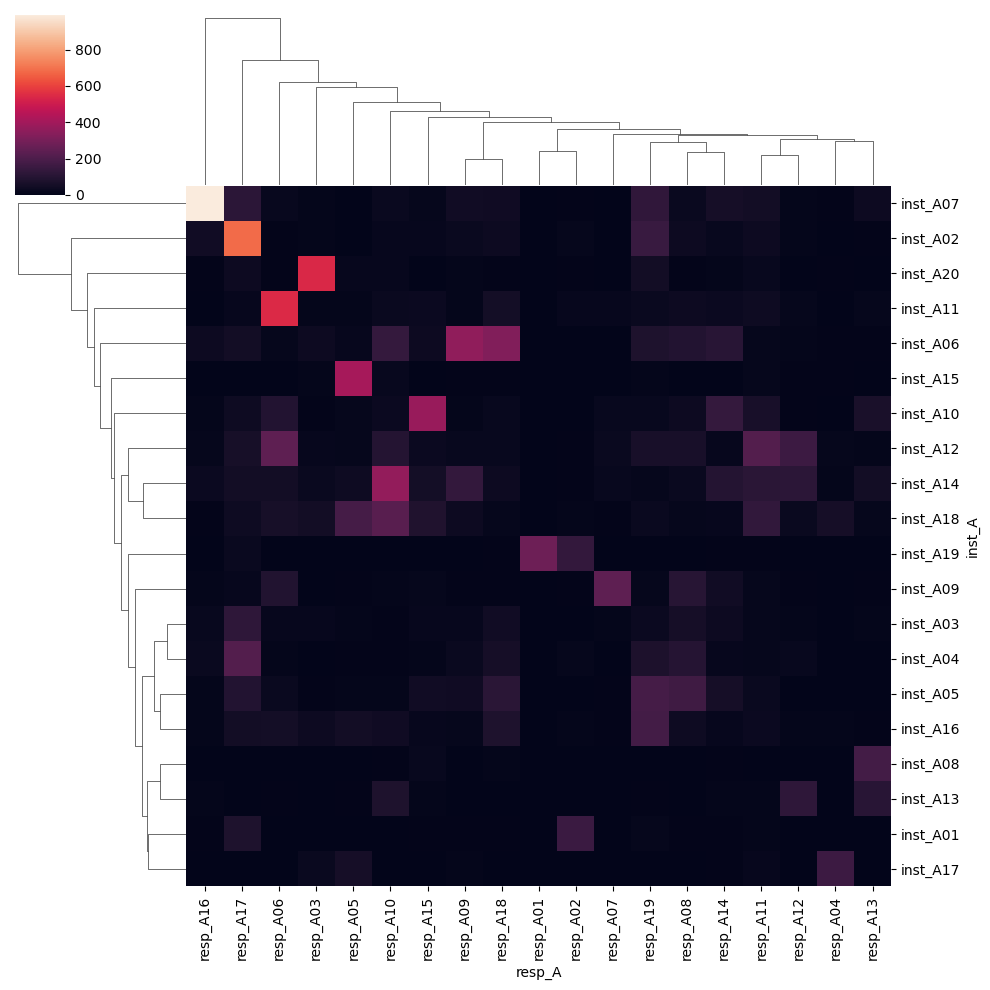

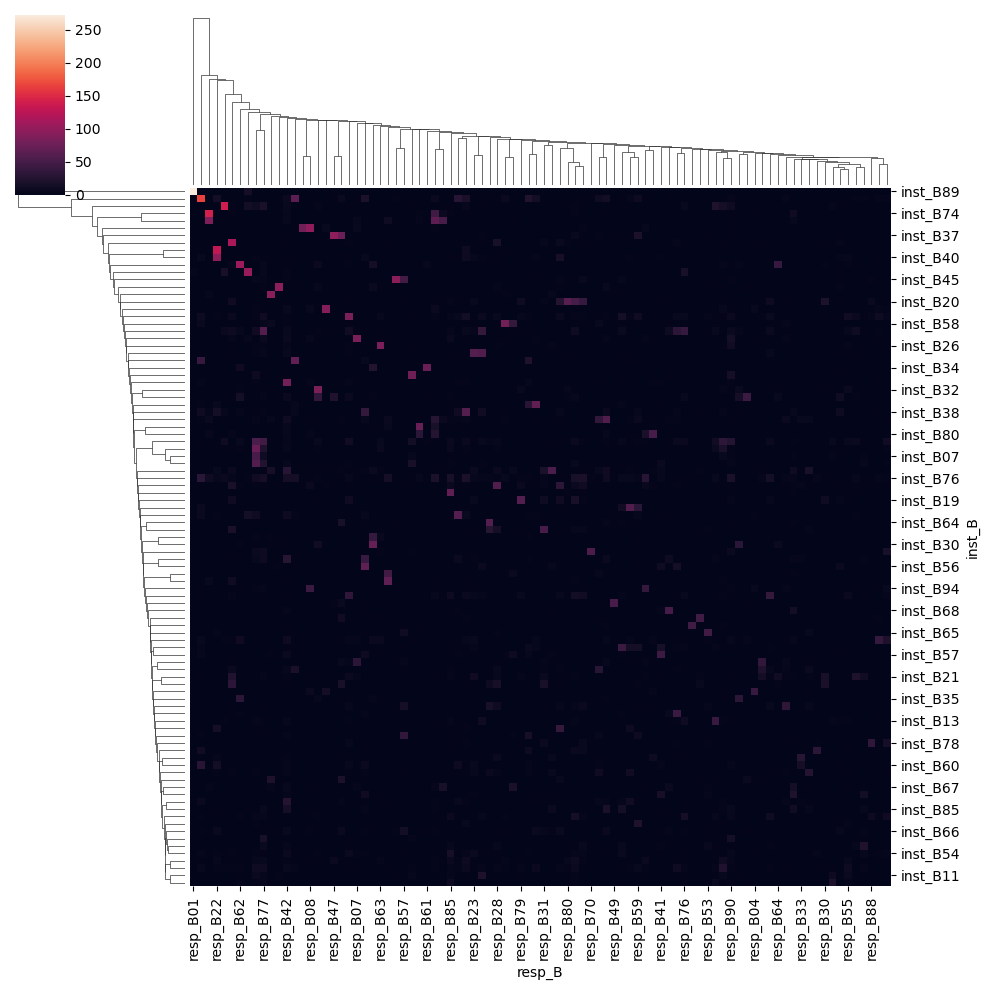

In [10]:
import seaborn as sns

for letter in 'AB':
    X = pd.crosstab(dolly_data[f'inst_{letter}'], dolly_data[f'resp_{letter}'])
    sns.clustermap(X)

In [11]:
dd_wide = dolly_data[ ['category', 'inst_B', 'resp_B'] ] \
    .reset_index() \
    .rename(columns={'index':'basket', 'inst_B': 'instruction_cluster', 'resp_B': 'response_cluster'})

basket_item = pd.melt(dd_wide, 
                        id_vars='basket', 
                        value_vars=['category', 'instruction_cluster', 'response_cluster'],
                        var_name='type', value_name='thing'
                     ).sort_values(['basket', 'type'])

basket_item['item'] = basket_item['type'] + '::' + basket_item['thing']

basket_item = basket_item[ ['basket', 'item']]

basket_item

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 18, Finished, Available)

,basket,item
4651,0,category::closed_qa
19662,0,instruction_cluster::inst_B38
34673,0,response_cluster::resp_B25
8845,1,category::classification
23856,1,instruction_cluster::inst_B93
...,...,...
18318,15009,instruction_cluster::inst_B49
33329,15009,response_cluster::resp_B19
11406,15010,category::general_qa
26417,15010,instruction_cluster::inst_B56


In [12]:
def get_item_pair_stats(item_pair_df):
    # item_pair_df must have columns named 'basket', and 'item'.
    
    import sqlite3

    db = sqlite3.connect(":memory:")
    
    item_pair_df.to_sql("basket_item", db, if_exists="replace")


    ITEM_PAIR_STATS_QUERY = """with 
      bi as (
        select basket, item
          from basket_item
          group by basket, item  -- be sure we only count one of each kind of item per basket
      ),
      item_counts as (
        select item, count(*) item_count -- same as the number of baskets containing this item (see above)
          from bi
          group by item
      ),
      bi_count as (
        select bi.*, ic.item_count  -- basket, item, item_count
          from bi
            join item_counts ic on bi.item=ic.item
      ),
      ips as (
          select bi1.item item1, bi2.item item2,
                  bi1.item_count item1_count, bi2.item_count item2_count,
                  count(*) as both_count              
              from bi_count bi1
                join bi_count bi2  -- joining the table to itself
                  on bi1.basket = bi2.basket  -- two items in the same basket
                  and bi1.item != bi2.item    -- don't count the item being in the basket with itself
              group by bi1.item, bi1.item_count, 
                       bi2.item, bi2.item_count
      ),
      cc as (
        SELECT item1, item2, item1_count, item2_count, both_count,
              CAST(item1_count AS FLOAT)/(select count(distinct basket) from basket_item) as item1_prevalence, -- fraction of all baskets with item1
              CAST(item2_count AS FLOAT)/(select count(distinct basket) from basket_item) as item2_prevalence, -- fraction of all baskets with item2
              CAST(both_count AS FLOAT)/CAST(item1_count AS FLOAT) AS confidence  -- fraction of baskets with item1 that also have item2
          FROM ips
      )
    select *, confidence/item2_prevalence lift from cc
    """

    return pd.read_sql_query(ITEM_PAIR_STATS_QUERY, db)


def get_nodes_and_edges_from_item_pair_stats(cooccurrence_pdf):
    """
    Convert a Pandas dataframe of item-pair statistics to separate dataframes for nodes and edges.
    """
    from collections import Counter
    
    item_stats = {r['item1']:{'count':r['item1_count'], 'prevalence':r['item1_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()}
 
    item_stats.update({r['item2']:{'count':r['item2_count'], 'prevalence':r['item2_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()})
 
    nodes_df = pd.DataFrame([{'label':k,'count':v['count'], 'prevalence':v['prevalence']}  
                    for k,v in item_stats.items()])
    nodes_df['id'] = nodes_df.index
   
    edges_df = cooccurrence_pdf.copy()
    node_id = {r['label']:r['id'] for idx, r in nodes_df.iterrows()}
    edges_df['from'] = [node_id[nn] for nn in edges_df['item1']]
    edges_df['to'] = [node_id[nn] for nn in edges_df['item2']]
    
    print("Your graph will have {0} nodes and {1} edges.".format( len(nodes_df), len(edges_df) ))
 
    return nodes_df, edges_df[[ 'from', 'to', 'both_count', 'confidence', 'lift']]


def get_vis_js_html(nodes_df, edges_df):
    """
    Generate HTML encoding vis_js graph from Pandas dataframes of nodes and edges.
    """
    nodes_str = nodes_df.to_json(orient='records')
    edges_str = edges_df.to_json(orient='records')
    
    max_weight = max(edges_df['weight'])

    html_string = ( 
    f'    <script type="text/javascript">NODE_LIST={nodes_str};FULL_EDGE_LIST={edges_str};</script>\n'
    '\n'
        '\n'
    '        <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>\n'
    '        <script type="text/javascript">\n'
    '            function hello(){console.info("hello")}\n'
    '\n'
    '            const sign_color = {pos:"blue", neg:"red", zero:"black"}\n'
    '            const options = {physics:{maxVelocity: 1, minVelocity: 0.01}}\n'
    '            var edgeFilterSlider\n'
    '            var mynetwork\n'
    '            var motion_flag = false\n'
    '            function toggle_motion(){\n'
    '                motion_flag = !motion_flag\n'
    '                mynetwork.setOptions( { physics: motion_flag } )\n'
    '            }\n'
    '\n'
    '            function edgesFilter(edge){\n'
    '                return edge.value >= edgeFilterSlider.value\n'
    '            }\n'
    '\n'
    '            function init_network(){\n'
    '                document.getElementById("min_edge_weight_display").value = 0.5\n'
    '                document.getElementById("min_edge_weight").onchange = function(){\n'
    '                    document.getElementById("min_edge_weight_display").value = this.value\n'
    '                }\n'
    '\n'
    '                edgeFilterSlider = document.getElementById("min_edge_weight")\n'
    '                edgeFilterSlider.addEventListener("change", (e) => {edgesView.refresh()})\n'
    '                var container = document.getElementById("mynetwork")\n'
    '                var EDGE_LIST = []\n'
    '                for (var i = 0; i < FULL_EDGE_LIST.length; i++) {\n'
    '                    var edge = FULL_EDGE_LIST[i]\n'
    '                    edge["value"] = Math.abs(edge["weight"])\n'
    '                    edge["title"] = "weight " + edge["weight"]\n'
    '                    edge["sign"] = (edge["weight"] < 0) ? "neg" : "pos";\n'
    '                    edge["color"] = {color: sign_color[edge["sign"]] };\n'
    '                    edge["arrows"] = "to"\n'
    '                    EDGE_LIST.push(edge)\n'
    '                }\n'
    '\n'
    '                var nodes = new vis.DataSet(NODE_LIST)\n'
    '                var edges = new vis.DataSet(EDGE_LIST)\n'
    '                var nodesView = new vis.DataView(nodes)\n'
    '                var edgesView = new vis.DataView(edges, { filter: edgesFilter })\n'
    '                var data = { nodes: nodesView, edges: edgesView }\n'
    '                mynetwork = new vis.Network(container, data, options)\n'
    '\n'
    '            }\n'
    '            init_network()\n'
    '        </script>\n'
    '        <style type="text/css">#mynetwork {width: 100%; height: 500px; border: 3px}</style>\n'
    '        <button onclick=toggle_motion()>Toggle motion</button>\n'
    '        <div class="slidercontainer">\n'
    '            <label>minimum edge weight:\n'
    f'                <input type="range" min="0" max="{max_weight}" value="{max_weight/2}" step="{max_weight/100}" class="slider" id="min_edge_weight">\n'
    '                <input type="text" id="min_edge_weight_display" size="2">\n'
    '            </label>\n'
    '        </div>\n'
    '        <div id="mynetwork"></div>\n'

    )
    return html_string
        
    
def export_to_vis_js(nodes_df, edges_df, title, html_file_name):
    """
    Generate vis_js graph from Pandas dataframes of nodes and edges, and write to HTML file.
    """
    
    vis_js_html = get_vis_js_html(nodes_df, edges_df)
    page_html =  ('<!DOCTYPE html>\n'
        '<html lang="en">\n'
        '    <head>\n'
        f'       <title>{title}</title>\n'
        '    </head>\n'
        '    <body onload=init_network()>\n'
        f'{vis_js_html}'
        '\n'
        '    </body>\n'
        '</html>\n')
    
    with open(html_file_name, "wt") as html_file: 
        html_file.write(page_html)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 19, Finished, Available)

In [13]:
item_pair_stats = get_item_pair_stats(basket_item)

item_pair_stats.sort_values('confidence', ascending=False)[0:15]

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 20, Finished, Available)

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
1706,instruction_cluster::inst_B09,category::information_extraction,141,1506,141,0.009393,0.100326,1.000000,9.967463
1471,instruction_cluster::inst_B02,category::open_qa,50,3742,49,0.003331,0.249284,0.980000,3.931261
4921,response_cluster::resp_B01,instruction_cluster::inst_B89,279,292,272,0.018586,0.019452,0.974910,50.117739
4913,response_cluster::resp_B01,category::classification,279,2136,270,0.018586,0.142296,0.967742,6.800924
5033,response_cluster::resp_B06,instruction_cluster::inst_B95,81,208,78,0.005396,0.013857,0.962963,69.495370
5028,response_cluster::resp_B06,category::classification,81,2136,78,0.005396,0.142296,0.962963,6.767339
4727,instruction_cluster::inst_B89,category::classification,292,2136,277,0.019452,0.142296,0.948630,6.666614
4732,instruction_cluster::inst_B89,response_cluster::resp_B01,292,279,272,0.019452,0.018586,0.931507,50.117739
7475,response_cluster::resp_B70,instruction_cluster::inst_B06,60,111,55,0.003997,0.007395,0.916667,123.964715
3009,instruction_cluster::inst_B41,category::classification,113,2136,103,0.007528,0.142296,0.911504,6.405708


In [22]:
nodes, edges = get_nodes_and_edges_from_item_pair_stats( item_pair_stats[ item_pair_stats['both_count'] > 15 ] )

nodes = nodes.rename(columns={'label':'type_label'})
nodes

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 32, Finished, Available)

Your graph will have 193 nodes and 1660 edges.


,type_label,count,prevalence,id
0,category::brainstorming,1766,0.117647,0
1,category::classification,2136,0.142296,1
2,category::closed_qa,1773,0.118113,2
3,category::creative_writing,709,0.047232,3
4,category::general_qa,2191,0.145960,4
...,...,...,...,...
188,response_cluster::resp_B86,102,0.006795,188
189,response_cluster::resp_B87,262,0.017454,189
190,response_cluster::resp_B88,78,0.005196,190
191,response_cluster::resp_B89,142,0.009460,191


In [31]:
type_color = {'category': '#FF9999', 'instruction_cluster': '#99FFFF', 'response_cluster': '#FFFF99'}

# use different shapes for categories that use context and those that do not
category_shape = {'brainstorming': 'box', 'classification': 'box', 'creative_writing': 'box', 
                  'general_qa': 'box', 'open_qa': 'box',
                  'closed_qa': 'star', 'information_extraction': 'star', 'summarization': 'star',
                  'instruction_cluster': 'ellipse', 'response_cluster': 'ellipse'}

nodes['type'] = [ x.split('::')[0] for x in nodes['type_label'] ]
nodes['label'] = [ x.split('::')[1] for x in nodes['type_label'] ]     # text displayed on the node
nodes['color'] = [ type_color[my_type] for my_type in nodes['type'] ]

   
nodes['shape'] = [ category_shape[row['label']] if row['type'] == 'category' else 'ellipse' for row in nodes.to_dict(orient='records') ]

def make_node_title(row, text_df):
    title = f"{row['label']}\n({row['type']}, {row['count']} examples)"
    if row['type'] == 'instruction_cluster':
        cluster_id = row['label']
        examples = text_df[ text_df['inst_B'] == cluster_id ]['instruction'].sample(6).values
        title += '\n' + '\n'.join(examples)
    if row['type'] == 'response_cluster':
        cluster_id = row['label']
        examples = text_df[ text_df['resp_B'] == cluster_id ]['response'].sample(6).values
        title += '\n' + '\n'.join(examples)        
    return title

nodes['title'] = [ make_node_title(row, dolly_data) for row in nodes.to_dict(orient='records') ]


nodes

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 41, Finished, Available)

,type_label,count,prevalence,id,type,label,color,shape,title
0,category::brainstorming,1766,0.117647,0,category,brainstorming,#FF9999,box,"brainstorming\n(category, 1766 examples)"
1,category::classification,2136,0.142296,1,category,classification,#FF9999,box,"classification\n(category, 2136 examples)"
2,category::closed_qa,1773,0.118113,2,category,closed_qa,#FF9999,star,"closed_qa\n(category, 1773 examples)"
3,category::creative_writing,709,0.047232,3,category,creative_writing,#FF9999,box,"creative_writing\n(category, 709 examples)"
4,category::general_qa,2191,0.145960,4,category,general_qa,#FF9999,box,"general_qa\n(category, 2191 examples)"
...,...,...,...,...,...,...,...,...,...
188,response_cluster::resp_B86,102,0.006795,188,response_cluster,resp_B86,#FFFF99,ellipse,"resp_B86\n(response_cluster, 102 examples)\nTh..."
189,response_cluster::resp_B87,262,0.017454,189,response_cluster,resp_B87,#FFFF99,ellipse,"resp_B87\n(response_cluster, 262 examples)\nTh..."
190,response_cluster::resp_B88,78,0.005196,190,response_cluster,resp_B88,#FFFF99,ellipse,"resp_B88\n(response_cluster, 78 examples)\nMao..."
191,response_cluster::resp_B89,142,0.009460,191,response_cluster,resp_B89,#FFFF99,ellipse,"resp_B89\n(response_cluster, 142 examples)\nKa..."


In [32]:
edges['weight'] = edges['confidence']

edges[edges['weight'] > 0.25]

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 42, Finished, Available)

,from,to,both_count,confidence,lift,weight
1426,8,6,99,0.335593,1.346229,0.335593
1429,8,105,139,0.471186,32.897580,0.471186
1471,9,6,49,0.980000,3.931261,0.980000
1480,9,179,17,0.340000,13.831274,0.340000
1492,10,6,114,0.300000,1.203447,0.300000
...,...,...,...,...,...,...
8195,189,6,76,0.290076,1.163639,0.290076
8209,189,23,86,0.328244,15.207638,0.328244
8244,190,2,22,0.282051,2.387971,0.282051
8268,190,85,33,0.423077,64.149573,0.423077


In [33]:
vis_js_html = get_vis_js_html(nodes, edges[edges['confidence'] > 0.25])

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 43, Finished, Available)

In [34]:
from IPython.display import HTML

HTML(vis_js_html)

StatementMeta(, 93c4a3f3-be0d-4d6f-be59-dffc9fcb37a2, 44, Finished, Available)